In [43]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

In [10]:
df = pd.read_csv('data/Housing_SalePrice_US.csv')
df.head()

,DATE,MSPUS
0,1963-01-01,17800.0
1,1963-04-01,18000.0
2,1963-07-01,17900.0
3,1963-10-01,18500.0
4,1964-01-01,18500.0


In [5]:
# Datetime objects are easier to work with

print(df.info())

df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')

# After
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    237 non-null    object 
 1   MSPUS   237 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.8+ KB
None


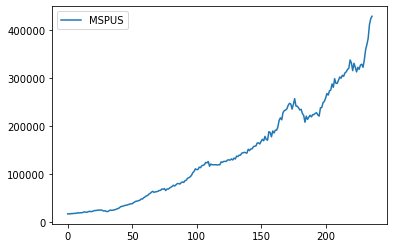

In [12]:
df.plot()
plt.show()

In [47]:
macro_df = pd.read_csv('data/Macroecon_US.csv')

# Get the Date column in to a format strftime can handle
macro_df['Date'] = macro_df['Date'].astype('str') + '.01'  # Assume data is from the first of each month
macro_df['Date'] = macro_df['Date'].str.replace('.', '-')
print(macro_df.head())

# Convert to datetime object
macro_df['Date'] = pd.to_datetime(macro_df['Date'], format='%Y.%m')

macro_df.head()

         Date  S&P Comp.  Dividend  Earnings    Consumer Price Index CPI  \
0  1871-01-01       4.44      0.26       0.4                       12.46   
1  1871-02-01       4.50      0.26       0.4                       12.84   
2  1871-03-01       4.61      0.26       0.4                       13.03   
3  1871-04-01       4.74      0.26       0.4                       12.56   
4  1871-05-01       4.86      0.26       0.4                       12.27   

   Date Fraction    Long Interest Rate GS10  Real Price  Real Dividend  \
0          1871.04                     5.32      103.43           6.06   
1          1871.13                     5.32      101.72           5.88   
2          1871.21                     5.33      102.68           5.79   
3          1871.29                     5.33      109.58           6.01   
4          1871.38                     5.33      114.97           6.15   

   Real Total Return Price   ...  Excess CAPE Yield  \
0                   103.43   ...           

/tmp/ipykernel_879/4168380678.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  macro_df['Date'] = macro_df['Date'].str.replace('.', '-')


,Date,S&P Comp.,Dividend,Earnings,Consumer Price Index CPI,Date Fraction,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,...,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns,10 Year Annualized Stock Real Return,10 Year Annualized Bonds Real Return,Real 10 Year Excess Annualized Returns,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1871-01-01,4.44,0.26,0.4,12.46,1871.04,5.32,103.43,6.06,103.43,...,NaN,1.0,1.00,13.06%,9.25%,3.81%,NaN,NaN,NaN,NaN
1,1871-02-01,4.50,0.26,0.4,12.84,1871.13,5.32,101.72,5.88,102.21,...,NaN,1.0,0.97,13.09%,9.46%,3.62%,NaN,NaN,NaN,NaN
2,1871-03-01,4.61,0.26,0.4,13.03,1871.21,5.33,102.68,5.79,103.66,...,NaN,1.0,0.96,13.10%,9.62%,3.48%,NaN,NaN,NaN,NaN
3,1871-04-01,4.74,0.26,0.4,12.56,1871.29,5.33,109.58,6.01,111.13,...,NaN,1.0,1.00,12.21%,9.10%,3.11%,NaN,NaN,NaN,NaN
4,1871-05-01,4.86,0.26,0.4,12.27,1871.38,5.33,114.97,6.15,117.11,...,NaN,1.0,1.03,12.26%,8.95%,3.31%,NaN,NaN,NaN,NaN


In [21]:
supply_df = pd.read_csv('data/Monthly_Supply_New_Houses_US.csv')
supply_df.head()

KeyError: 'Date'

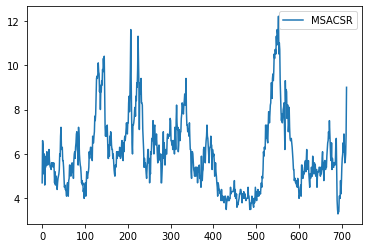

In [19]:
supply_df.plot()
plt.show()